In [19]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle
import operator
import matplotlib
import scipy.stats as stats
import statsmodels.stats.multitest as multi
from itertools import chain
from sklearn.preprocessing import minmax_scale
plt.rcParams['figure.figsize'] = [15, 10]
import warnings; warnings.simplefilter('ignore')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# raw data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/
# please download: BF-beta_cortex_he.tsv, aba_he.zip

Load definitions

In [10]:
def Extract(lst): 
    return list(next(zip(*lst))) 

def ftest(st_spec_cutoff,aba_spec_cutoff):
    bb_count = 0
    fisher_dict = {}
    pval_list = []

    for condition, df in st_spec_cutoff.groupby('condition_1'):

            regions_tmp = list(set(st_spec_cutoff['AAR1'].tolist()))
            regions = [x for x in regions_tmp if str(x) != 'nan']

            for i in regions:     
                for j in regions:

                    #SM-Omics genes
                    st_genes = df[df['AAR1'] == i]['gene_new'].tolist()

                    # ABA-genes
                    aba_genes = aba_spec_cutoff[aba_spec_cutoff['ABA_region'] == j]['gene-symbol'].tolist()

                    # SM-Omics genes in all other regions
                    st_rest = df[df['AAR1'] != i]['gene_new'].tolist()

                    # ABA genes in all other regions
                    aba_rest = aba_spec_cutoff[aba_spec_cutoff['ABA_region'] != j]['gene-symbol'].tolist()

                    # g1 = genes in both ST and ABA
                    # g2 = genes unique to ST
                    # g3 = genes unique to ABA
                    # g4 = genes neither in st or aba region but in the other regions

                    g1 = len(list(set(st_genes).intersection(aba_genes)))
                    g2 = len(list(set(aba_genes).difference(set(st_genes)))) 
                    g3 = len(list(set(st_genes).difference(set(aba_genes))))
                    g4 = len(list(set(st_rest).intersection(aba_rest)))

                    # Fisher's test
                    oddsratio, pvalue = stats.fisher_exact([[g4, g2], [g3, g1]], alternative='greater')

                    # Store pvalues in list to use for multiple corrections testing
                    pval_list.append(pvalue)

                    # Store fisher's test results in DF
                    ff = [condition, i, j, oddsratio, pvalue, g1]
                    # print(i, j, g1, g2, g3, g4, pvalue)

                    if bb_count == 0:
                        fisher_dict[bb_count] = ff

                        df_ff = pd.DataFrame.from_dict(fisher_dict)

                        df_ff['idx'] = ['condition', 'AAR_ST', 'AAR_ABA','Odds ratio', 'p value', 'Num shared genes']

                        df_ff.set_index('idx', inplace = True)

                        bb_count += 1
                    else:
                        df_ff[bb_count] = ff

                        bb_count += 1
    return pval_list, df_ff

def read_array_metadata(metadata,filename,n_levels, extraplot=None):
    array_metadata = metadata[metadata['Count file'] == filename]
    array_levels = [array_metadata['Level %d'%(idx+1)].values[0] for idx in range(0,n_levels)]
    
    if extraplot != None:
        array_levels = array_metadata['Extra_plot_level'].tolist()
    return array_levels

def Extract(lst): 
    return list(next(zip(*lst))) 

def rename_lambdas_index(lambdas_file): 
    nwe=[]
    nm=lambdas_file.index
    for item in nm:
        nwe.append(str(item).split("_")[0])
    return nwe

In [853]:
# Load ABA ref files
path = '../../smomics_data/aba_MOB'

aba_dict = []
# Read files
for filename in glob.glob(os.path.join(path, 'aba*.csv')):
    
    # Get name of ABA region
    name = filename.split('/')[-1].split('.')[0][7:].upper()
    file = pd.read_csv(filename, index_col=0)
    file['ABA_region'] = name
    
    # Only keep certain columns
    aba = file[['gene-symbol', 'fold-change', 'ABA_region', 'target-sum', 'contrast-sum', 'num-target-samples', 'num-contrast-samples']]
        
    # Calculate expression threshold
    aba['Expression target'] = aba['target-sum'] / aba['num-target-samples']
    aba['Expression contrast'] = aba['contrast-sum'] / aba['num-contrast-samples']
    
    # Only save genes which have fold-change > xx
    aba = aba[aba['fold-change'] > 0] 
    aba_dict.append(aba)
    
aba_spec = pd.concat(aba_dict)

# merge region names
aba_spec['ABA_region'] = aba_spec['ABA_region'].replace({'PAA' : 'PIR',
                                                         'TR' : 'PIR',
                                                        'PRT' : 'MB',
                                                        'PAG' : 'MB'})

In [896]:
# Pick genes to correlate to SM-Omics signals per region
genes = ['Ctgf', 'Camk4', 'Lancl3', 'Cbln4', 'Nr2f2',]



In [878]:
# Load SM-Omics data for MOB

In [879]:
# # Load Lambda pmean df
# path = '../../smomics_data'

# # Read file
# filename = os.path.join(path, 'lambdas_pmeans_output_mob.tsv')
# lambda_posterior_means = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1],low_memory=False)
# lambda_posterior_means.index = rename_lambdas_index(lambda_posterior_means)


In [880]:
# # Take exp()
# lambda_posterior_means = lambda_posterior_means.astype(float)
# lambda_posterior_means = np.exp(lambda_posterior_means-1)

In [892]:
annot_path = '../../smomics_data'

annot_list = []

for stdata in list(set(gene_scale['name'].tolist())):
    
    well = stdata.split('_stdata')[0]
    
    filename = os.path.join(annot_path, well + '_annotations.txt')

    annot_file = pd.read_csv(filename, sep = '\t')
    
    # Remove 'Unknown'
    #file = file[file['value'] != 'Unknown']
   
    # Change to int if spot coord are in decimals
    if len(annot_file['x_y'][0].split('.')) == 3: # Spot coord in decimals

        # Detect which delimiter separates the spot coord
        if len(annot_file['x_y'][0].split('_')) == 2:
            delimi = '_'
        elif len(annot_file['x_y'][0].split('x')) == 2:
            delimi = 'x'
        else:
            print('Unknown spot coordinate delimiter.')

        # Round up
        annot_file['x'] = annot_file['x'].round(0)
        annot_file['y'] = annot_file['y'].round(0)

        # Make columns to int type
        annot_file['x'] = annot_file['x'].astype(int)
        annot_file['y'] = annot_file['y'].astype(int)

        # Make columns to string type
        annot_file['x'] = annot_file['x'].astype(str)
        annot_file['y'] = annot_file['y'].astype(str)

        # Make a new columnwith the rounded values
        annot_file['spot_coord'] = annot_file[['x', 'y']].apply(lambda z: '_'.join(z), axis=1)
        annot_file.drop(['x_y'], axis=1, inplace=True)
        annot_file.rename(columns = {'spot_coord':'x_y'}, inplace=True)

    # Keep certain columns:
    annot_file = annot_file.loc[:, ['image', 'x_y', 'value']]
    
    annot_list.append(annot_file)
    
# Concat
annotdf = pd.concat(annot_list)
annotdf = annotdf[annotdf['value'] != 'Unknown']
annotdf = annotdf[annotdf['value'].isin([i for i in annotdf['value'] if ";" not in i])]
annotdf['region'] = [i.split("(")[1].split(")")[0] for i in annotdf.value]
annotdf['region'] = annotdf['region'].replace({'GCL-D' : 'GR',
                                               'GCL-E' : 'GR',
                                               'M/T' : 'MI',
                                               'EPL' : 'OPL'})
annotdf = annotdf[annotdf['region'] != 'ONL']

In [908]:
gene_scaled = []
gene_names = []
for gene in genes:

    # reset index
    if gene in lambda_posterior_means.index:
        lambda_gene = lambda_posterior_means.loc[gene, :].to_frame().reset_index()
        #print(gene)
    
        # Get name of file, for plotting
        lambda_gene['name'] = lambda_gene['file'].str.split('/').str[-1].str.split('_stdata').str[0]

        # Scales within each sample
        gene_scale = lambda_gene.copy()
        gene_scale[gene+'.scaled'] = gene_scale.groupby('name')[gene].transform(lambda x: minmax_scale(x))

        # connects to annotation areas
        lambdadf = pd.merge(gene_scale, annotdf, how='left', left_on=['name','coordinate'], right_on=['image', 'x_y'])
        lambdadf = lambdadf.dropna(axis = 0)
        gene_scaled.append(list(pd.DataFrame(lambdadf.groupby('region')[gene].mean()).transform(lambda x: minmax_scale(x))[gene]))
        #gene_scaled.append(np.mean(lambdadf[gene]))
        gene_names.append(gene)
sm_df = pd.DataFrame(gene_scaled).T
sm_df.columns = gene_names
sm_df.index = lambdadf.groupby('region')[gene].mean().index
sm_df['Condition'] = 'sm-omics'       

In [913]:
aba_scaled = []
gene_names = []
for gene in genes:
    if gene in list(aba_spec['gene-symbol']):
        abs_gene = aba_spec[aba_spec['gene-symbol'] == gene]
        #print(np.log(pd.DataFrame(abs_gene.groupby('ABA_region')['Expression target'].mean()).transform(lambda x: minmax_scale(x))))
        aba_scaled.append(list(pd.DataFrame((abs_gene.groupby('ABA_region')['fold-change'].mean())).transform(lambda x: minmax_scale(x))['fold-change']))
        gene_names.append(gene)
        
aba_df = pd.DataFrame(aba_scaled).T
aba_df.columns = gene_names
aba_df.index = abs_gene.groupby('ABA_region')['Expression target'].mean().index
aba_df['Condition'] = 'aba'

In [916]:
aba_df

,Ctgf,Camk4,Lancl3,Cbln4,Nr2f2,Condition
ABA_region,,,,,,
GL,1.000000,1.00000,0.201309,1.000000,1.000000,aba
GR,0.000000,0.33969,0.000000,0.000000,0.000000,aba
IPL,0.513920,0.00000,0.466448,0.523772,0.137064,aba
MI,0.713252,NaN,1.000000,0.681458,0.536902,aba
OPL,0.777283,NaN,0.315876,0.950872,0.439578,aba


In [915]:
"Make list for corplots"
corr_df = pd.DataFrame([[item for sublist in aba_scaled for item in sublist],[item for sublist in gene_scaled for item in sublist]]).T
corr_df.columns = ['aba', 'sm-omics']
corr_df['region'] = list(np.unique(abs_gene.groupby('ABA_region')['Expression target'].mean().index))*len(gene_names)
corr_df['gene'] = [j for j in gene_names for i in np.unique(abs_gene.groupby('ABA_region')['Expression target'].mean().index)]
corr_df = corr_df.fillna(0)

ValueError: Length of values (25) does not match length of index (23)

KeyError: 'gene'

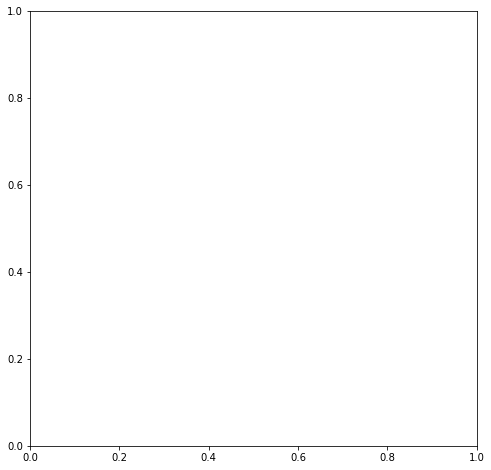

In [912]:
for gene in genes:
    # Plot
    from scipy.stats import linregress, spearmanr, pearsonr
    # initialize a figure
    fig, ax = plt.subplots(figsize=(8, 8))

    x = 'sm-omics'
    y = 'aba'
    hue = 'region'
    style = 'gene'
    corr_df_sub = corr_df[corr_df['gene'] == gene]

    sns.scatterplot(x=x, y=y, hue=hue, style = style, data=corr_df_sub, ax=ax, s=50, linewidth=0)

    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(corr_df_sub[x], corr_df_sub[y])

    coef = np.polyfit(corr_df_sub[x],corr_df_sub[y],1)
    poly1d_fn = np.poly1d(coef)
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x]), c="k")
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])+std_err, c="grey")
    ax.plot(corr_df_sub[x], poly1d_fn(corr_df_sub[x])-std_err, c="grey")
    #ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

    # Spearman's & Pearson's r
    spear, pspear = spearmanr(corr_df_sub[x], corr_df_sub[y])
    pear, p = pearsonr(corr_df_sub[x], corr_df_sub[y])
    print(gene)
    print("Spearman's r: " + str(round(spear, 3)))
    print("Spearman's p value: " + str(pspear))
    ax.text(0.05, 0.9, "Spearman's r: " + str(round(spear, 3)), transform=ax.transAxes, fontsize=15)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

    #plt.savefig("IFvsGENE_Neun.pdf", transparent=True, bbox_inches = 'tight',
    #    pad_inches = 0, dpi=1200, rasterized=True)